**Back story:**  

Using data from the web (API or scraped) or one of the optional supplied data sets (possibly in conjunction with your own data), create models using supervised learning techniques. Extend your findings with a flask website and/or OPTIONAL D3 visualization.

Note you can work as a 'group' (with other folks working on the same data source as you) for brainstorming, design, additional data, etc. However, the final projects will be individual.

**Data:**

**acquisition:** download, api's, scraping, etc.  
**storage:** PostgreSQL  
**example sources:** (see sql_data_sets for descriptions and links to data.)

### Thoughts:

- Use soccer data to develop a model that predicts whether a team will win / lose
- Feature selection will need to be performed, given the scope of features available
- Models to consider: KNN; Logistic Regression
- Other things to consider: classification error; ROC curve; 

## First, we need to get the data

Initial data pull is from Kaggle; document is a **.sqlite** file; so we will need to pull the data into Python

In [205]:
import sqlite3
from sqlite3 import Error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import collections
from itertools import cycle

# from __future__ import division
# pd.set_option('display.width',5000)

# transforming categorical data
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# for statsmodel
import statsmodels.formula.api as smf
import statsmodels.api as sm

# for scikitlearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn import linear_model as lm
from sklearn import svm, datasets
from scipy import interp

# classification errors
from sklearn.metrics import confusion_matrix, precision_recall_curve, make_scorer
from sklearn.metrics import roc_curve, auc, recall_score, accuracy_score, precision_score
from sklearn.metrics import classification_report


# sklearn models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

# for pickling
import pickle

from datetime import datetime

## trying to come up with SQL script to calculate home win / away win per match record

## Pickle all the data into separate pickle files (one per table)

In [279]:
path_folder = 'data/'
# list_of_tables = ['country_table','league_table','match_table','player_table','player_attr_table',
#                   'sqlite_sequence_table','team_table','team_attr_table']

## Preview of all the table data

In [5]:
league_table.head(3)

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1


In [6]:
country_table.head(3)

,id,name
0,1,Belgium
1,1729,England
2,4769,France


## merge league + country tables by id

In [703]:
league_country_table = pd.merge(league_table,country_table,on='id')

# rename the columns 
league_country_table = league_country_table.rename(columns={"name_x": "league", "name_y": "country"})

league_country_table

,id,country_id,league,country
0,1,1,Belgium Jupiler League,Belgium
1,1729,1729,England Premier League,England
2,4769,4769,France Ligue 1,France
3,7809,7809,Germany 1. Bundesliga,Germany
4,10257,10257,Italy Serie A,Italy
5,13274,13274,Netherlands Eredivisie,Netherlands
6,15722,15722,Poland Ekstraklasa,Poland
7,17642,17642,Portugal Liga ZON Sagres,Portugal
8,19694,19694,Scotland Premier League,Scotland
9,21518,21518,Spain LIGA BBVA,Spain


### next we create dummy variables for each country (country_id = league_id)

In [704]:
#from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# transform feature country into numerical representation
country_le = LabelEncoder()
country_labels = country_le.fit_transform(league_country_table['country'])
country_mappings = {index: label for index, label in 
                  enumerate(country_le.classes_)}

# map the transformed country data to the main table
league_country_table['country_label'] = country_labels

# creating dummy variables for each country
country_ohe = OneHotEncoder()
country_feature_arr = country_ohe.fit_transform(league_country_table[['country_label']]).toarray()
country_feature_labels = list(country_le.classes_)
country_features = pd.DataFrame(country_feature_arr, columns=country_feature_labels)

# concatenate dummary variables to overall league_country_table
league_country_df_ohe = pd.concat([league_country_table, country_features], axis=1)
columns = sum([list(league_country_table.columns),   
               country_feature_labels], [])

#league_country_df_ohe[columns]
league_country_df_ohe

,id,country_id,league,country,country_label,Belgium,England,France,Germany,Italy,Netherlands,Poland,Portugal,Scotland,Spain,Switzerland
0,1,1,Belgium Jupiler League,Belgium,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1729,1729,England Premier League,England,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4769,4769,France Ligue 1,France,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7809,7809,Germany 1. Bundesliga,Germany,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10257,10257,Italy Serie A,Italy,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,13274,13274,Netherlands Eredivisie,Netherlands,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,15722,15722,Poland Ekstraklasa,Poland,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,17642,17642,Portugal Liga ZON Sagres,Portugal,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,19694,19694,Scotland Premier League,Scotland,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,21518,21518,Spain LIGA BBVA,Spain,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Team data

## team_table + team_attr_table

In [197]:
team_table.head(3)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL


In [9]:
team_attr_table.head(3)

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover


## Creating a new team table, with transformed data - to be used as features later

Following features need to be updated:
- buildUpPlaySpeedClass
- buildUpPlayDribblingClass
- chanceCreationShootingClass
- chanceCreationPositioningClass
- defencePressureClass
- defenceAggressionClass
- defenceTeamWidthClass
- defenceDefenderLineClass

In [705]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [706]:
# list of features to transform
team_attr_list = ['buildUpPlaySpeedClass','buildUpPlayDribblingClass','chanceCreationShootingClass',
                  'chanceCreationPositioningClass','defencePressureClass','defenceAggressionClass',
                  'defenceTeamWidthClass','defenceDefenderLineClass']

### Helper function to:
- convert categorical features into dummy variables
- create a 'date_year' column

In [755]:
def transform_team_cat_features(feature):
    
    # transform feature into numerical representation
    le = LabelEncoder()
    feature_labels = le.fit_transform(team_attr_table[feature])
    feature_mappings = {index: label for index, label in enumerate(le.classes_)}
    temp_table = pd.DataFrame(feature_labels,columns = [feature])
    
    # encode labels using one-hot encoding scheme
    ohe = OneHotEncoder()
    feature_arr = ohe.fit_transform(temp_table[[feature]]).toarray()
    feature_labels = list(le.classes_)
    
    # update feature names
    for c, value in enumerate(feature_labels, 1):
        feature_labels[c-1] = feature +'_'+ feature_labels[c-1]
    
    # create and return DataFrame of dummy variables
    features = pd.DataFrame(feature_arr, columns=feature_labels)
    return features

def date_year(row):
    return row['date'][:4]

### Code to prepare a transformed team attribute table (team_attr_table_transformed)

In [756]:
# build a new table with transformed categorical data (dummy variables)

# adding first four columns
team_attr_table_transformed = team_attr_table.iloc[:,0:4]

# concatenate all the ordinal features
ordinal_feat_table = team_attr_table.loc[:,['buildUpPlaySpeed','buildUpPlayDribbling','buildUpPlayPassing',
                                            'chanceCreationPassing','chanceCreationCrossing',
                                            'chanceCreationShooting','defencePressure','defenceAggression',
                                            'defenceTeamWidth']]

team_attr_table_transformed = pd.concat([team_attr_table_transformed,ordinal_feat_table],axis=1)

# convert all the categorical features to dummy variables and concatenate to transformed table
for feature in team_attr_list:
    
    # check if categorical feature has any nulls (replace name in filter)
    if len(team_attr_table.loc[team_attr_table[feature].isnull()]) > 0:
        print('Feature ' + feature + ' has nulls - please check!')
    
    else:
        # call helper function to generate DataFrame of dummy variables
        temp_dummy_df = transform_team_cat_features(feature)
        
        # concatenate dummy variables DataFrame with main transformed table
        team_attr_table_transformed = pd.concat([team_attr_table_transformed,temp_dummy_df],axis=1)    

### We also need to impute for missing data on ordinal features

There are 288 unique teams in the dataset - we will group by each team and impute the mean for each ordinal feature

In [757]:
# list of all the teams
unique_teams_list = list(team_attr_table_transformed['team_api_id'].unique())

# iterate through each team and impute the mean for each ordinal feature missing values
for team in unique_teams_list:
    
    # impute team features with missing data - using each team's means (rather than means of all teams)
    imputed_data_temp = team_attr_table_transformed.loc[team_attr_table_transformed['team_api_id']==team,].fillna(
       team_attr_table_transformed.loc[team_attr_table_transformed['team_api_id']==team,].mean())
    
    # drop initial rows of team attributes from main dataframe
    team_attr_table_transformed = team_attr_table_transformed.drop(index=team_attr_table_transformed.loc[
        team_attr_table_transformed['team_api_id']==team,].index)
    
    # concat newly imputed rows into main dataframe
    team_attr_table_transformed = team_attr_table_transformed.append(imputed_data_temp)

# impute remaining NaNs with overall table means
team_attr_table_transformed = team_attr_table_transformed.fillna(round(team_attr_table_transformed.mean(),1))

# create 'date_year' column to capture the year of team stats (pulling from 'date' column)
team_attr_table_transformed['date_year'] = team_attr_table_transformed.apply(lambda row: date_year(row),axis=1)

## Final team attribute table - transformed

In [758]:
team_attr_table_transformed.head(3)

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,...,defencePressureClass_Medium,defenceAggressionClass_Contain,defenceAggressionClass_Double,defenceAggressionClass_Press,defenceTeamWidthClass_Narrow,defenceTeamWidthClass_Normal,defenceTeamWidthClass_Wide,defenceDefenderLineClass_Cover,defenceDefenderLineClass_Offside Trap,date_year
0,1,434,9930,2010-02-22 00:00:00,60,44.5,50,60,65,55,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2010
1,2,434,9930,2014-09-19 00:00:00,52,48.0,56,54,63,64,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2014
2,3,434,9930,2015-09-10 00:00:00,47,41.0,54,54,63,64,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2015


# Next we need to transform match_table

Irrelevant features:
- league_id (equivalent to country_id)
- match_api_id
- season (TBD)

In [759]:
# initialize transformed match_table
match_table_transformed = match_table.iloc[:,:11]

In [760]:
# these are the columns of interest
match_table_transformed.columns[0:11]

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal'],
      dtype='object')

In [761]:
match_table_transformed.iloc[:3,]

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3


## Look at below code if time permitted

In [692]:
# add 'previous_winner' column
match_table_sorted['previous_winner']=""
home_team = match_table_sorted['home_team_api_id'][0]
away_team = match_table_sorted['away_team_api_id'][0]



for i in range(len(match_table_sorted)):
    if i == 0:
        match_table_sorted['previous_winner'][i]='draw'
    elif (home_team == match_table_sorted['home_team_api_id'][i]) & (away_team == match_table_sorted['away_team_api_id'][i]):
        match_table_sorted['previous_winner'][i] = match_table_sorted['winner'][int(i-1)]
    else:
        home_team = match_table_sorted['home_team_api_id'][i]
        away_team = match_table_sorted['away_team_api_id'][i]
        match_table_sorted['previous_winner'][i]='draw'


/Users/auyeus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/auyeus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/auyeus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()

KeyboardInterrupt

### we need to transform the match_table in a few ways:
- include date_year column for merging later
- create a 'goal_difference' column
- based on 'goal_difference' column, calculate winner (e.g. home, away, draw)

In [762]:
# create new column that captures the goal difference between home team  vs. away team
match_table_transformed['goal_difference'] = match_table_transformed['home_team_goal'] - match_table_transformed['away_team_goal']

### Helper function to define the winner, based on goal differences

In [763]:
def label_winner(row):
    if row['goal_difference'] == 0:
        return 'draw'
    elif row['goal_difference'] > 0:
        return 'home'
    else:
        return 'away'

In [764]:
# create new column, 'winner', that defines who won, or if a draw
match_table_transformed['winner'] = match_table_transformed.apply(lambda row: label_winner(row),axis=1)

In [765]:
# create a 'date_year' feature based on 'date' column (for merging later) - using helper function from before
match_table_transformed['date_year'] = match_table_transformed.apply(lambda row: date_year(row),axis=1)

In [766]:
match_table_transformed.head(3)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,goal_difference,winner,date_year
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,0,draw,2008
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,0,draw,2008
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,-3,away,2008


# Now we need to combine team attributes with each match record

Specifically, we want to include both the home + away teams' attributes

In [767]:
team_attr_table_transformed.head(1)

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,...,defencePressureClass_Medium,defenceAggressionClass_Contain,defenceAggressionClass_Double,defenceAggressionClass_Press,defenceTeamWidthClass_Narrow,defenceTeamWidthClass_Normal,defenceTeamWidthClass_Wide,defenceDefenderLineClass_Cover,defenceDefenderLineClass_Offside Trap,date_year
0,1,434,9930,2010-02-22 00:00:00,60,44.5,50,60,65,55,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2010


In [137]:
match_table_transformed.head(1)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,goal_difference,winner,date_year
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,0,draw,2008


In [768]:
team_attr_table_transformed.columns

Index(['id', 'team_fifa_api_id', 'team_api_id', 'date', 'buildUpPlaySpeed',
       'buildUpPlayDribbling', 'buildUpPlayPassing', 'chanceCreationPassing',
       'chanceCreationCrossing', 'chanceCreationShooting', 'defencePressure',
       'defenceAggression', 'defenceTeamWidth',
       'buildUpPlaySpeedClass_Balanced', 'buildUpPlaySpeedClass_Fast',
       'buildUpPlaySpeedClass_Slow', 'buildUpPlayDribblingClass_Little',
       'buildUpPlayDribblingClass_Lots', 'buildUpPlayDribblingClass_Normal',
       'chanceCreationShootingClass_Little',
       'chanceCreationShootingClass_Lots',
       'chanceCreationShootingClass_Normal',
       'chanceCreationPositioningClass_Free Form',
       'chanceCreationPositioningClass_Organised', 'defencePressureClass_Deep',
       'defencePressureClass_High', 'defencePressureClass_Medium',
       'defenceAggressionClass_Contain', 'defenceAggressionClass_Double',
       'defenceAggressionClass_Press', 'defenceTeamWidthClass_Narrow',
       'defenceTeamWidt

In [769]:
# list of columns from team_attr_table_transformed that are important
imp_cols = ['team_api_id','buildUpPlaySpeed',
       'buildUpPlayDribbling', 'buildUpPlayPassing', 'chanceCreationPassing',
       'chanceCreationCrossing', 'chanceCreationShooting', 'defencePressure',
       'defenceAggression', 'defenceTeamWidth',
       'buildUpPlaySpeedClass_Balanced', 'buildUpPlaySpeedClass_Fast',
       'buildUpPlaySpeedClass_Slow', 'buildUpPlayDribblingClass_Little',
       'buildUpPlayDribblingClass_Lots', 'buildUpPlayDribblingClass_Normal',
       'chanceCreationShootingClass_Little',
       'chanceCreationShootingClass_Lots',
       'chanceCreationShootingClass_Normal',
       'chanceCreationPositioningClass_Free Form',
       'chanceCreationPositioningClass_Organised', 'defencePressureClass_Deep',
       'defencePressureClass_High', 'defencePressureClass_Medium',
       'defenceAggressionClass_Contain', 'defenceAggressionClass_Double',
       'defenceAggressionClass_Press', 'defenceTeamWidthClass_Narrow',
       'defenceTeamWidthClass_Normal', 'defenceTeamWidthClass_Wide',
       'defenceDefenderLineClass_Cover',
       'defenceDefenderLineClass_Offside Trap', 'date_year']

# merge home team attributes with match_table first
merge_table_initial = match_table_transformed.merge(team_attr_table_transformed[imp_cols], 
                                            how='left',left_on=['home_team_api_id','date_year'],
                                            right_on=['team_api_id','date_year'])

# merge away team attributes with match_table
merge_table_secondary = merge_table_initial.merge(team_attr_table_transformed[imp_cols], 
                                            how='left',left_on=['away_team_api_id','date_year'],
                                            right_on=['team_api_id','date_year'])

# Also need to merge country data with all the other data

This is to see if country/league plays a role in predicting game outcome

In [770]:
# merge the country (to see if leagues have any influence on model)
merge_table_final = merge_table_secondary.merge(league_country_df_ohe[['country_id','Belgium','England','France',
                                                                       'Germany','Italy','Netherlands','Poland',
                                                                       'Portugal','Scotland','Spain','Switzerland']],
                                                                        how='left',on='country_id')

# Pickle the merge_table_final

In [3]:
path_folder = 'data/'

In [157]:
# save merge_table_final
with open(path_folder + 'merge_table_final.pkl','wb') as picklefile:
    pickle.dump(merge_table_final,picklefile)


In [4]:
# load pickle files
with open(path_folder + 'merge_table_final.pkl','rb') as picklefile:
    merge_table_final = pickle.load(picklefile)

In [5]:
merge_table_final.head(3)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,England,France,Germany,Italy,Netherlands,Poland,Portugal,Scotland,Spain,Switzerland
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Something to note: there appears to be only team attributes data between 2010 thru 2015 

(missing 2008, 2009, and 2016)

In [6]:
merge_table_final['date_year'].unique()

array(['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016'], dtype=object)

In [8]:
team_attr_table_transformed['date_year'].unique() 

# looks like we do not have team attributes data for 2008, 2009, or 2016

NameError: name 'team_attr_table_transformed' is not defined

### Drop records that have NaN team attribute data

In [776]:
merge_table_final.loc[merge_table_final['buildUpPlaySpeed_x'].isnull(),['date_year']].count()

# 7,163 records without home team attribute

date_year    7163
dtype: int64

In [777]:
# first drop records that are missing home team attributes
df_semi_clean = merge_table_final.loc[merge_table_final['buildUpPlaySpeed_x'].notnull()]

# second, with the DataFrame that has home team attributes, drop records that are missing away team attributes
df_clean = df_semi_clean.loc[df_semi_clean['buildUpPlaySpeed_y'].notnull()]

In [778]:
# check if any other columns / features have NaN
for feature in df_clean.columns:
    if len(df_clean.loc[df_clean[feature].isnull()]) > 0:
        print(feature + ' has null data')

In [779]:
len(df_clean) # number of records remaining

18243

### Pickle the initial dataset for modeling (no NaNs)

In [215]:
path_folder = 'data/'

# save merge_table_final
with open(path_folder + 'df_clean.pkl','wb') as picklefile:
    pickle.dump(df_clean,picklefile)

In [9]:
# load pickle files
with open(path_folder + 'df_clean.pkl','rb') as picklefile:
    df_clean = pickle.load(picklefile)

In [10]:
# reset index
df_clean = df_clean.reset_index(drop=True)

## Let's check to see if log-transform or box-cox is required for ordinal features

In [11]:
# 18 features of interest - which we want to see histograms for

col_of_ints = ['buildUpPlaySpeed_x',
       'buildUpPlayDribbling_x', 'buildUpPlayPassing_x',
       'chanceCreationPassing_x', 'chanceCreationCrossing_x',
       'chanceCreationShooting_x', 'defencePressure_x', 'defenceAggression_x',
       'defenceTeamWidth_x','buildUpPlaySpeed_y', 'buildUpPlayDribbling_y', 'buildUpPlayPassing_y',
       'chanceCreationPassing_y', 'chanceCreationCrossing_y',
       'chanceCreationShooting_y', 'defencePressure_y', 'defenceAggression_y',
       'defenceTeamWidth_y']

### Per histograms of each ordinal feature, looks like features are pretty nicely distributed. We will skip log transform

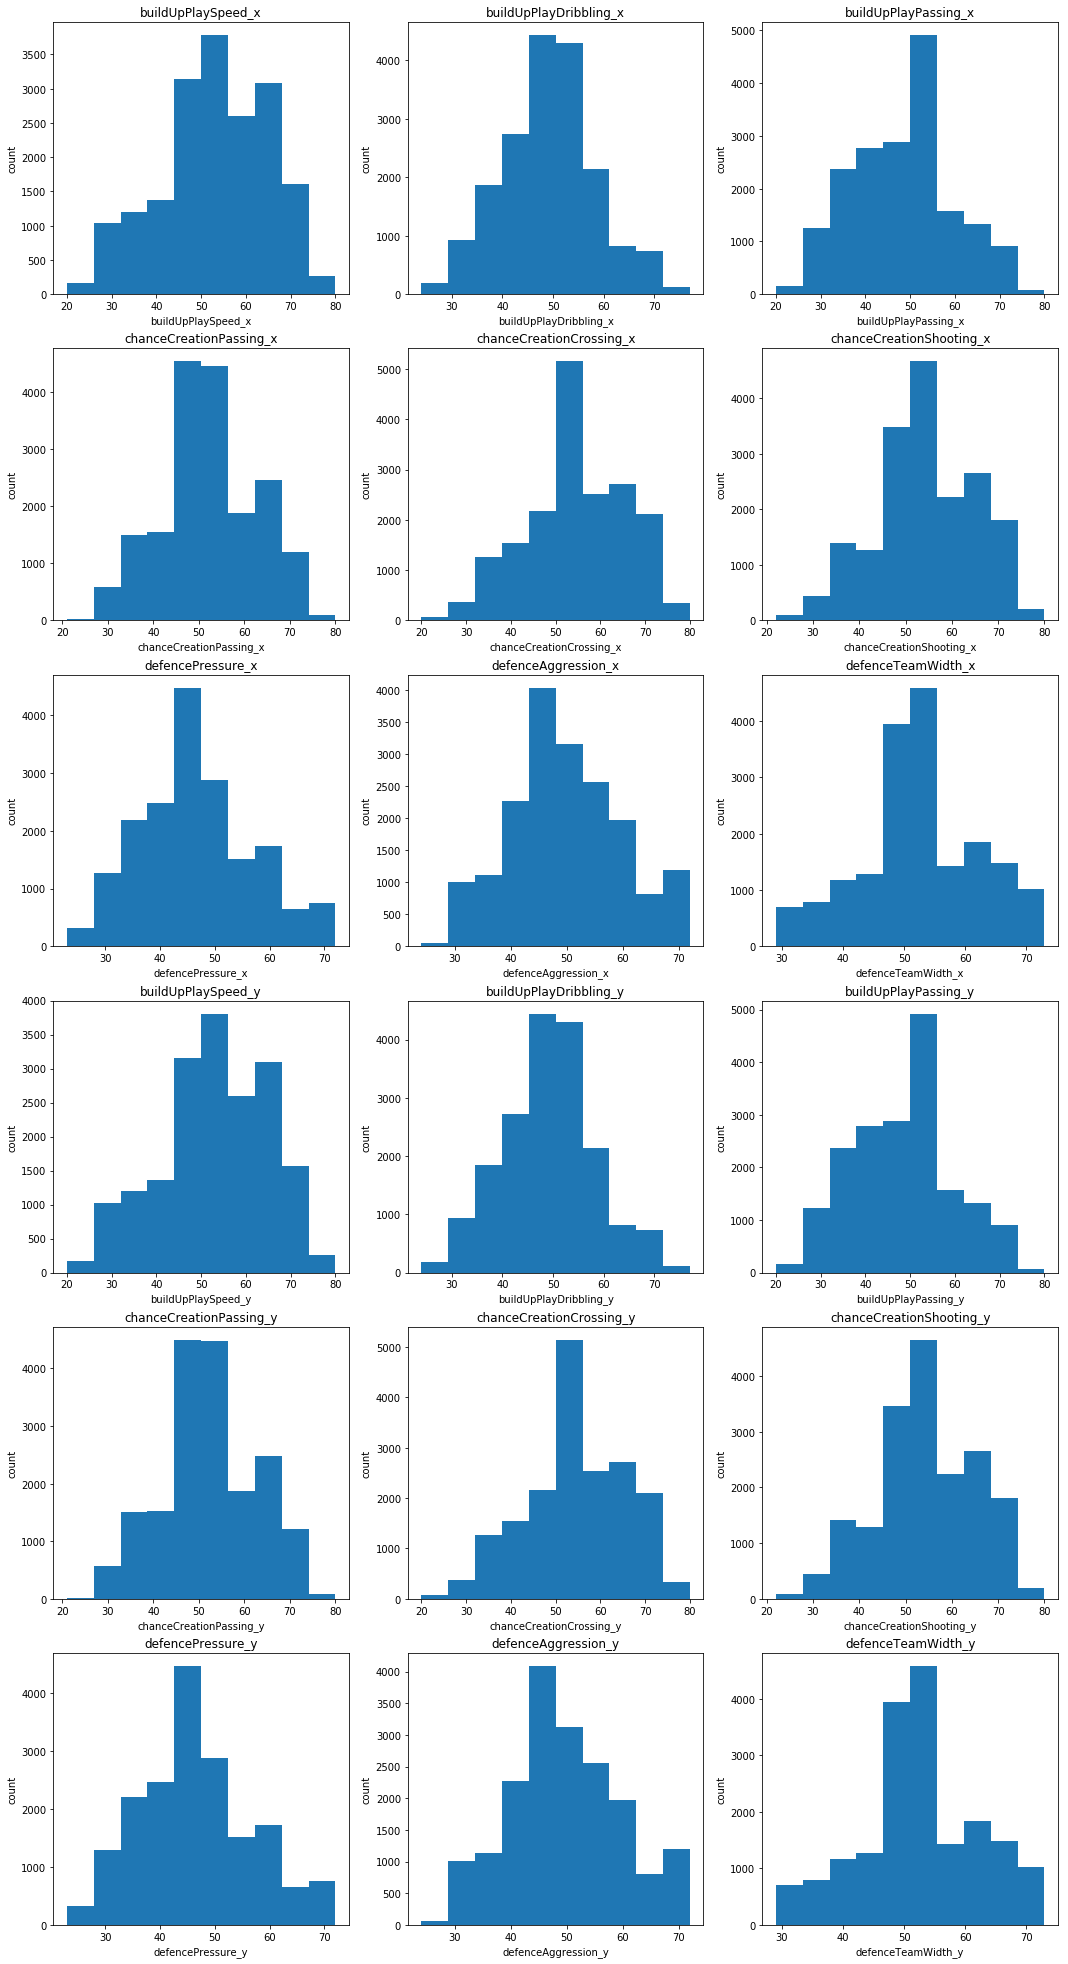

In [783]:
#histogram of all features + response variable
plt.figure(figsize=(18,35))
counter = 1

for feature in col_of_ints:
    plt.subplot(6,3,counter)
    plt.hist(df_clean[feature])
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel("count")
    counter += 1

# Model Time

In [12]:
# first, define the y target variable + X features
y = df_clean['winner']
X = df_clean.loc[:,['buildUpPlaySpeed_x','buildUpPlayDribbling_x', 'buildUpPlayPassing_x','chanceCreationPassing_x', 
                    'chanceCreationCrossing_x','chanceCreationShooting_x', 'defencePressure_x', 'defenceAggression_x',
                    'defenceTeamWidth_x', 'buildUpPlaySpeedClass_Balanced_x','buildUpPlaySpeedClass_Fast_x', 
                    'buildUpPlaySpeedClass_Slow_x','buildUpPlayDribblingClass_Little_x',
                    'buildUpPlayDribblingClass_Lots_x','buildUpPlayDribblingClass_Normal_x',
                    'chanceCreationShootingClass_Little_x','chanceCreationShootingClass_Lots_x',
                    'chanceCreationShootingClass_Normal_x','chanceCreationPositioningClass_Free Form_x',
                    'chanceCreationPositioningClass_Organised_x','defencePressureClass_Deep_x', 
                    'defencePressureClass_High_x','defencePressureClass_Medium_x', 'defenceAggressionClass_Contain_x',
                    'defenceAggressionClass_Double_x', 'defenceAggressionClass_Press_x','defenceTeamWidthClass_Narrow_x', 
                    'defenceTeamWidthClass_Normal_x','defenceTeamWidthClass_Wide_x', 'defenceDefenderLineClass_Cover_x',
                    'defenceDefenderLineClass_Offside Trap_x','buildUpPlaySpeed_y', 'buildUpPlayDribbling_y', 
                    'buildUpPlayPassing_y','chanceCreationPassing_y', 'chanceCreationCrossing_y',
                    'chanceCreationShooting_y', 'defencePressure_y', 'defenceAggression_y','defenceTeamWidth_y', 
                    'buildUpPlaySpeedClass_Balanced_y','buildUpPlaySpeedClass_Fast_y', 'buildUpPlaySpeedClass_Slow_y',
                    'buildUpPlayDribblingClass_Little_y','buildUpPlayDribblingClass_Lots_y',
                    'buildUpPlayDribblingClass_Normal_y','chanceCreationShootingClass_Little_y',
                    'chanceCreationShootingClass_Lots_y','chanceCreationShootingClass_Normal_y',
                    'chanceCreationPositioningClass_Free Form_y','chanceCreationPositioningClass_Organised_y',
                    'defencePressureClass_Deep_y', 'defencePressureClass_High_y',
                    'defencePressureClass_Medium_y', 'defenceAggressionClass_Contain_y',
                    'defenceAggressionClass_Double_y', 'defenceAggressionClass_Press_y',
                    'defenceTeamWidthClass_Narrow_y', 'defenceTeamWidthClass_Normal_y',
                    'defenceTeamWidthClass_Wide_y', 'defenceDefenderLineClass_Cover_y',
                    'defenceDefenderLineClass_Offside Trap_y', 'Belgium', 'England',
                    'France', 'Germany', 'Italy', 'Netherlands', 'Poland', 'Portugal',
                    'Scotland', 'Spain', 'Switzerland']]

# split the data into training set + test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


### standardize the features in X_train (this doesn't seem to work...)

In [726]:
# attributes to standardize (non-dummy variables)
attr_to_stand = ['buildUpPlaySpeed_x', 'buildUpPlayDribbling_x', 'buildUpPlayPassing_x',
       'chanceCreationPassing_x', 'chanceCreationCrossing_x',
       'chanceCreationShooting_x', 'defencePressure_x', 'defenceAggression_x',
       'defenceTeamWidth_x','buildUpPlaySpeed_y',
       'buildUpPlayDribbling_y', 'buildUpPlayPassing_y',
       'chanceCreationPassing_y', 'chanceCreationCrossing_y',
       'chanceCreationShooting_y', 'defencePressure_y', 'defenceAggression_y',
       'defenceTeamWidth_y']

In [785]:
scaler = StandardScaler()

# standardize the features' values
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Start modeling with training set!

## KNN

In [13]:
# 10-fold cross-validation with k = 20
knn = KNeighborsClassifier(n_neighbors=20)
print(cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy').mean())

0.4423694918707576


## adding parameter 'weight' for GridSearchCV to look at

In [302]:
# define the parameter values that should be searched
k_range = list(range(1, 20))
weight_options = ['uniform', 'distance']

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
#print(param_grid)

# instantiate and fit the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, y_train)

# view the complete results
grid.grid_scores_

/Users/auyeus/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.39859, std: 0.01504, params: {'n_neighbors': 1, 'weights': 'uniform'},
 mean: 0.39859, std: 0.01504, params: {'n_neighbors': 1, 'weights': 'distance'},
 mean: 0.36609, std: 0.01078, params: {'n_neighbors': 2, 'weights': 'uniform'},
 mean: 0.39499, std: 0.01601, params: {'n_neighbors': 2, 'weights': 'distance'},
 mean: 0.40948, std: 0.01215, params: {'n_neighbors': 3, 'weights': 'uniform'},
 mean: 0.40799, std: 0.01540, params: {'n_neighbors': 3, 'weights': 'distance'},
 mean: 0.41394, std: 0.01083, params: {'n_neighbors': 4, 'weights': 'uniform'},
 mean: 0.41433, std: 0.01495, params: {'n_neighbors': 4, 'weights': 'distance'},
 mean: 0.41691, std: 0.01664, params: {'n_neighbors': 5, 'weights': 'uniform'},
 mean: 0.42224, std: 0.01479, params: {'n_neighbors': 5, 'weights': 'distance'},
 mean: 0.43359, std: 0.01381, params: {'n_neighbors': 6, 'weights': 'uniform'},
 mean: 0.42561, std: 0.01064, params: {'n_neighbors': 6, 'weights': 'distance'},
 mean: 0.42999, std: 0.01214, para

In [304]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.44964761158966327
{'n_neighbors': 19, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=19, p=2,
           weights='uniform')


### Using best parameters to make a prediction on the test set

In [786]:
# train your model using all data and the best known parameters
knn = KNeighborsClassifier(n_neighbors=19, weights='uniform')
knn.fit(X_train, y_train)

# make a prediction on out-of-sample data
y_predict = knn.predict(X_test)

In [787]:
metrics.accuracy_score(y_test,y_predict) # accuracy score

0.4644619038918326

### Let's see what the KNN score would be like with a high k value (e.g. 100)

Looks like the higher the K value, the better the accuracy... let's see if other classification models are better

In [788]:
# 10-fold cross-validation with k = 100
knn = KNeighborsClassifier(n_neighbors=100)
print(cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy').mean())

0.4714177401752397


# Logistic Regression

In [789]:
# 10-fold cross-validation with logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(multi_class='multinomial',solver='newton-cg')
print(cross_val_score(logreg, X_train, y_train, cv=10, scoring='accuracy').mean())

0.4743967167759089


In [278]:
# converting y_train into numerical values
#y_train_test = y_train.astype('category').cat.codes

### logistic regression with statsmodels (can it do multinomial LR?)

In [361]:
X_train = sm.add_constant(X_train) # need to add constant manually - not a statsmodels default

In [362]:
logit_model = sm.MNLogit(y_train, X_train)
results = logit_model.fit()

         Current function value: 1.039570
         Iterations: 35


/Users/auyeus/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [363]:
results.summary()

/Users/auyeus/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:3967: RuntimeWarning: invalid value encountered in sqrt
  bse = np.sqrt(np.diag(self.cov_params()))
/Users/auyeus/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/auyeus/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/auyeus/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 winner   No. Observations:                12770
Model:                        MNLogit   Df Residuals:                    12656
Method:                           MLE   Df Model:                          112
Date:                Thu, 25 Oct 2018   Pseudo R-squ.:                 0.02335
Time:                        14:11:46   Log-Likelihood:                -13275.
converged:                      False   LL-Null:                       -13593.
                                        LLR p-value:                 5.406e-74
===============================================================================
winner=draw       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0919      0.025     -3.717      0.000      -0.140      -0.043
x1              0.0439      0.039      1.118      0.263      -0.033       0.121
x2              0.0317      0.033      0.960      0.337      -0.033       0.096
x3             -0.0180      0.030     -0.607      0.544      -0.076       0.040
x4             -0.0071      0.028     -0.253      0.800      -0.062       0.048
x5              0.0128      0.027      0.479      0.632      -0.040       0.065
x6             -0.0014      0.037     -0.038      0.970      -0.073       0.071
x7              0.0260      0.041      0.634      0.526      -0.054       0.106
x8              0.0355      0.038      0.928      0.353      -0.039       0.111
x9              0.0423      0.036      1.189      0.234      -0.027       0.112
x10            -0.0298   3.72e+06  -8.01e-09      1.000    -7.3e+06     7.3e+06
x11             0.0127   2.37e+06   5.36e-09      1.000   -4.65e+06    4.65e+06
x12             0.0295   1.75e+06   1.68e-08      1.000   -3.43e+06    3.43e+06
x13            -0.0206   1.75e+06  -1.18e-08      1.000   -3.42e+06    3.42e+06
x14             0.0129   5.15e+05   2.51e-08      1.000   -1.01e+06    1.01e+06
x15             0.0171   1.79e+06   9.54e-09      1.000    -3.5e+06     3.5e+06
x16             0.0090        nan        nan        nan         nan         nan
x17             0.0289        nan        nan        nan         nan         nan
x18            -0.0308        nan        nan        nan         nan         nan
x19             0.0254        nan        nan        nan         nan         nan
x20            -0.0254        nan        nan        nan         nan         nan
x21             0.0313   3.41e+06   9.17e-09      1.000   -6.69e+06    6.69e+06
x22             0.0242   1.95e+06   1.24e-08      1.000   -3.83e+06    3.83e+06
x23            -0.0408   3.99e+06  -1.02e-08      1.000   -7.83e+06    7.83e+06
x24             0.0021        nan        nan        nan         nan         nan
x25            -0.0005        nan        nan        nan         nan         nan
x26            -0.0010        nan        nan        nan         nan         nan
x27            -0.0093        nan        nan        nan         nan         nan
x28             0.0186        nan        nan        nan         nan         nan
x29            -0.0156   1.09e+06  -1.43e-08      1.000   -2.14e+06    2.14e+06
x30            -0.0436   5.14e+06  -8.49e-09      1.000   -1.01e+07    1.01e+07
x31             0.0436    5.7e+06   7.66e-09      1.000   -1.12e+07    1.12e+07
x32             0.0959      0.039      2.438      0.015       0.019       0.173
x33             0.0075      0.032      0.233      0.816      -0.056       0.071
x34             0.0492      0.030      1.639      0.101      -0.010       0.108
x35            -0.0240      0.028     -0.861      0.389      -0.079       0.031
x36            -0.0157      0.027     -0.584      0.559      -0.068       0.037
x37            -0.0350      0.037     -0.

## code below pending / may not be useful

### using sklearn logistic regression features

In [ ]:
X_train.drop('const', axis=1, inplace=True) # remove constant since sklearn defaults constants

In [368]:
logreg = LogisticRegression(multi_class='multinomial',solver='newton-cg')

In [320]:
c_range = list(np.logspace(-3, 1, 256)) # range of alphas (basically)
param_grid = dict(C=c_range) 

In [321]:
grid = GridSearchCV(logreg, param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=True)
# 'verbose = True' provides readout of GridSearchCV performance

In [322]:
grid.fit(X_train, y_train)

Fitting 10 folds for each of 256 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed:  7.9min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.001036779197060366, 0.001074911103457137, 0.0011144454707535626, 0.00115543388033544, 0.0011979298107105216, 0.0012419887072831308, 0.001287668054695046, 0.0013350274518270132, 0.0013841286895587572, 0.0014350358313889448, 0.0014878152970202849, 0.0015425359490188223, 0.00...8.347734492114153, 8.654757464007233, 8.973072494285637, 9.303094895789918, 9.64525525623346, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=True)

In [323]:
print(grid.best_estimator_)
print(grid.best_params_)
print(grid.best_score_)

LogisticRegression(C=0.02004291036814835, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
{'C': 0.02004291036814835}
0.4747063429913861


In [411]:
print ("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, grid.predict(X_train)))
print ("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, grid.predict(X_test)))

Multinomial Logistic regression Train Accuracy ::  0.4769772905246672
Multinomial Logistic regression Test Accuracy ::  0.4788964005116024


### Per the above results, it appears logistic regression is better than KNN.

### interpreting results

In [ ]:
results.summary()

Consider the coefficient of feature x.  This feature is measure in lifetime usage of feature x.

Increasing one's lifetime consumption of feature x by 1.o unit would increase the odds of home/away/draw by exp(0.0823) (relative to the control group) or  ~8.5 %

## Classification Errors

- confusion matrix
- ROC curve

**Helper functions below:**


In [239]:
# Generate a confusion matrix plot: 

def plot_confusion_matrix(cm,classes,title='Confusion Matrix', cmap=plt.cm.Reds):
    plt.figure(figsize=(15,10))
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
        
        
#Could be a typical function for classifying:

def train_score(classifier,x,y):
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=1234)
    ytrain=np.ravel(ytrain)
    clf = classifier.fit(xtrain, ytrain)
    
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = clf.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print(conf)
    
    cm=confusion_matrix(y_true, y_pred, labels=None)
    print('\n')
    print(classification_report(y_true,y_pred))
    
    plt.figure()
    plot_confusion_matrix(cm,classes=['away win','draw','home win'])

### running logistic regression on dataset - with class_weight = None

Training Data Accuracy: 0.48
Test Data Accuracy:     0.48
[[ 198    4  836]
 [ 123    2  793]
 [ 154    5 1534]]


             precision    recall  f1-score   support

       away       0.42      0.19      0.26      1038
       draw       0.18      0.00      0.00       918
       home       0.48      0.91      0.63      1693

avg / total       0.39      0.48      0.37      3649

Saving graph to: images/confusion_matrix_logreg.svg


<Figure size 432x288 with 0 Axes>

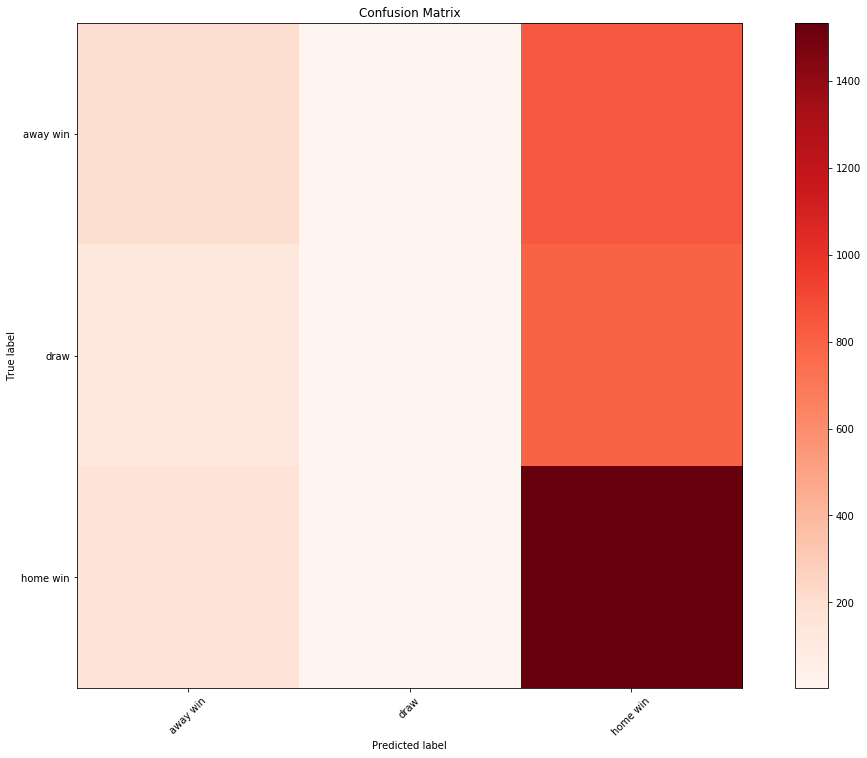

In [202]:
# test logistic regression
log_clf=LogisticRegression(multi_class='multinomial',solver='newton-cg',C=0.02004291036814835) # class_weight='None'
train_score(log_clf,X,y);

### running logistic regression on dataset with class_weight = 'balanced'

- Looks like classes 'away' and 'draw' have increases representation in the confusion matrix
- recall + F1 scores for classes 'away' and 'draw' have increased
- in contrast, the recall + F1 scores for class 'home' has decreased

Training Data Accuracy: 0.42
Test Data Accuracy:     0.41
[[477 253 308]
 [326 257 335]
 [505 417 771]]


             precision    recall  f1-score   support

       away       0.36      0.46      0.41      1038
       draw       0.28      0.28      0.28       918
       home       0.55      0.46      0.50      1693

avg / total       0.43      0.41      0.42      3649

Saving graph to: images/confusion_matrix_logreg.svg


<Figure size 432x288 with 0 Axes>

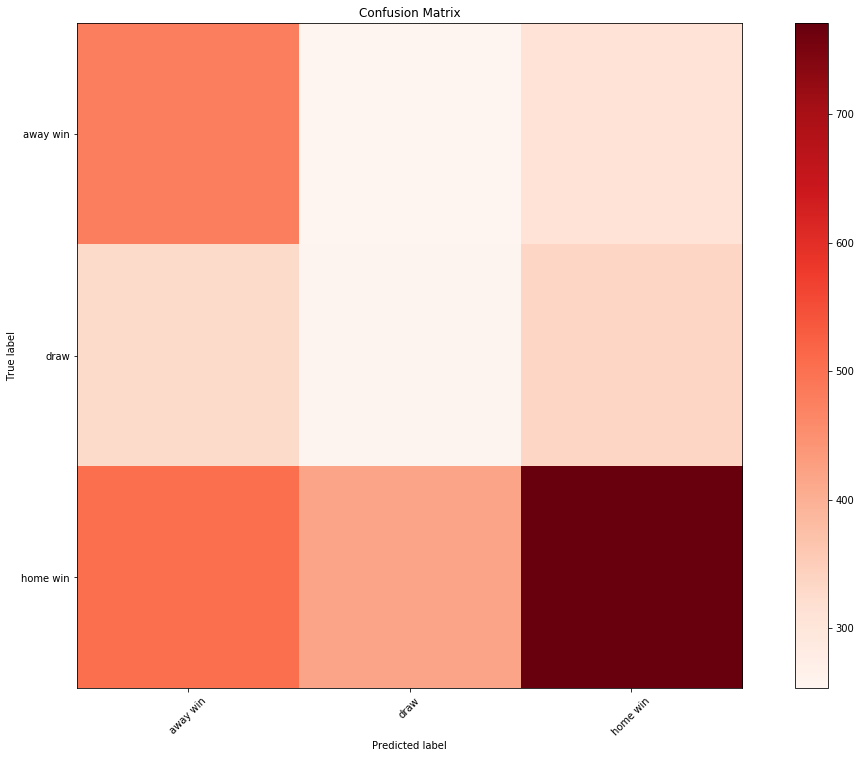

In [19]:
# test logistic regression
log_clf=LogisticRegression(multi_class='multinomial',solver='newton-cg',C=0.02004291036814835,class_weight='balanced')
train_score(log_clf,X,y);

In [ ]:
# test KNN

### ROC Curve

Using classifier OneVsRestClassifier (given multiclass situation)

In [21]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


# Binarize the output
y_roc = label_binarize(y, classes=['home', 'draw', 'away'])
n_classes = y_roc.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
# n_samples, n_features = X.shape
# X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train_roc, X_test_roc, y_train_roc, y_test_roc = train_test_split(X, y_roc, test_size=.5,
                                                    random_state=0)


# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(multi_class='multinomial',
                                                    solver='newton-cg',C=0.02004291036814835,
                                                    class_weight='balanced'),n_jobs=-1)
#classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,random_state=random_state))


y_score = classifier.fit(X_train_roc, y_train_roc).decision_function(X_test_roc)
#y_score = classifier.fit(X_train_roc, y_train_roc).predict_proba(X_test_roc)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


### ROC Curve for an individual class (one class vs. All)

Saving graph to: images/roc_curve_single_class.svg


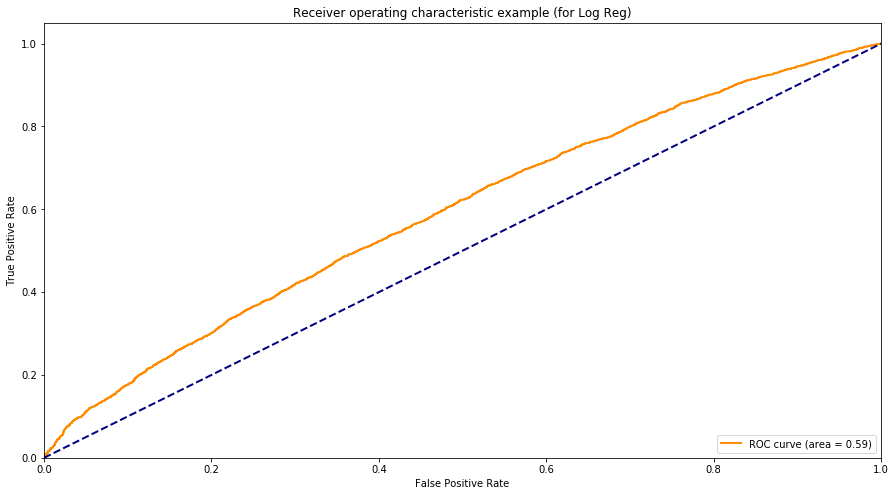

In [22]:
# define class (0 = home win; 1 = draw; 2 = away win)
class_n = 0

plt.figure(figsize=(15,8))
lw = 2
plt.plot(fpr[class_n], tpr[class_n], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[class_n])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example (for Log Reg)')
plt.legend(loc="lower right")


# Save options
save = 'images/roc_curve_single_class'

if save:
    print('Saving graph to:', save + '.svg')
    plt.savefig(save + '.svg', format='svg')

plt.show()

### ROC curves for all classes (one class vs. All)

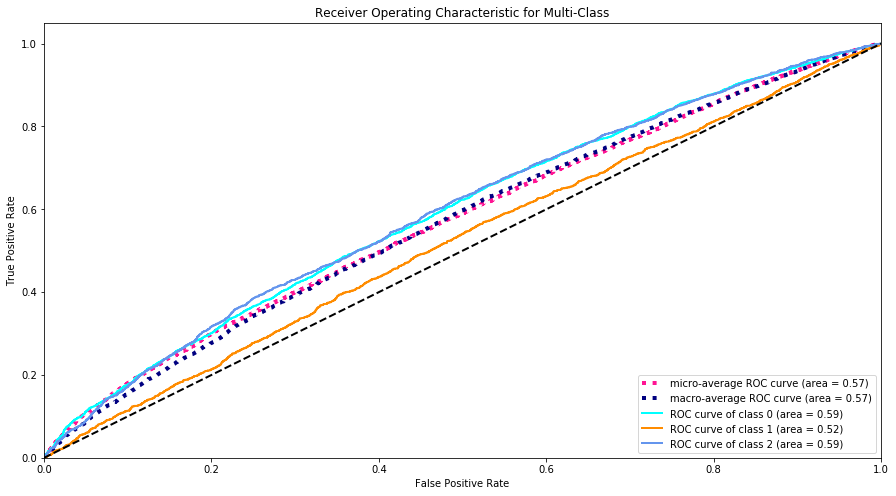

In [25]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

# Try to use GridSearchCV on SVM models (linear, poly, rbf)

In [ ]:
# fit linear model
model_svm = svm.SVC(kernel='linear')
model_svm.fit(X_train, y_train)

In [607]:
# predict out of sample
y_pred = model_svm.predict(X_test_svm)

In [608]:
# check accuracy
accuracy_score(y_test_svm,y_pred)


0.4633852225389169

In [ ]:
model_svm.coef_.shape

In [609]:
# confusion matrix
confusion_matrix(y_test_svm,y_pred)

array([[ 440,    0, 2190],
       [ 268,    0, 2031],
       [ 406,    0, 3787]])

In [596]:
# fit rbf model
model_svm2 = svm.SVC(kernel='rbf', gamma = 0.001)
model_svm2.fit(X_train_svm, y_train_svm)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [597]:
# predict out of sample
y_pred2_svm = model_svm2.predict(X_test_svm)

In [598]:
# check accuracy
accuracy_score(y_test_svm,y_pred2_svm)

0.46766060074545057

In [599]:
# confusion matrix
confusion_matrix(y_test_svm,y_pred2_svm)

array([[ 676,  146, 1808],
       [ 404,  120, 1775],
       [ 540,  183, 3470]])

In [601]:
print(classification_report(y_test_svm,y_pred2_svm))

             precision    recall  f1-score   support

       away       0.42      0.26      0.32      2630
       draw       0.27      0.05      0.09      2299
       home       0.49      0.83      0.62      4193

avg / total       0.41      0.47      0.40      9122



# Random Forest

### Helper functions to split data into training + test sets, and capturing mean score

In [27]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])


In [28]:
# Do the test 10 times with random forest and get the average score
randomforest = RandomForestClassifier(max_depth=5)
quick_test_afew_times(randomforest, X, y)

0.4742188927462087

### Now use GridSearchCV on random forest; check optimal max_depth + class_weight

In [882]:
# define the parameter values that should be searched
#estimate_range = list(range(10,100))
depth_range = list(range(1, 20))
weight_options = ['balanced', None]

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(max_depth=depth_range, class_weight=weight_options)
#print(param_grid)

randomforest = RandomForestClassifier()

clf = GridSearchCV(randomforest, param_grid, cv=10, scoring='accuracy',n_jobs=-1,verbose=True)
clf.fit(X_train,y_train)

Fitting 10 folds for each of 38 candidates, totalling 380 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 380 out of 380 | elapsed:   28.1s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=True)

In [886]:
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.46859827721221614
{'class_weight': None, 'max_depth': 5}


### based on gridsearchCV, we will use optimal max_depth and class_weight and look at feature importance

In [29]:
randomforest = RandomForestClassifier(max_depth=5,class_weight=None)
rf_model = randomforest.fit(X_train,y_train)
rf_model.score(X_test,y_test)

0.47980997624703087

In [30]:
# create dataframe of features and their associated importance
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(20)

,importance
defencePressure_x,0.087445
defencePressure_y,0.081704
buildUpPlayPassing_x,0.067383
buildUpPlayDribbling_y,0.053904
chanceCreationShootingClass_Normal_x,0.049116
chanceCreationPassing_y,0.045750
chanceCreationPositioningClass_Free Form_x,0.045564
chanceCreationPositioningClass_Free Form_y,0.044544
buildUpPlayPassing_y,0.039544
chanceCreationShooting_x,0.037720


In [225]:
# per the above, we are going to narrow our features
X_updated = X[['defencePressure_x','chanceCreationPositioningClass_Free Form_y','chanceCreationPositioningClass_Free Form_x',
   'buildUpPlayPassing_x','defencePressure_y','chanceCreationShooting_x','buildUpPlayPassing_y',
   'chanceCreationPositioningClass_Organised_x','buildUpPlayDribbling_x','chanceCreationPositioningClass_Organised_y',
   'chanceCreationPassing_x','defenceTeamWidth_x','chanceCreationCrossing_y','defenceAggression_y',
   'defenceTeamWidth_y','buildUpPlayDribbling_y','chanceCreationPassing_y','buildUpPlaySpeed_y']]

### split the data into training/test sets, with narrower number of features

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X_updated, y, test_size=0.3, stratify=y)

In [227]:
scaler = StandardScaler()

# standardize the features' values
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [973]:
# let's try GridSearchCV again

# define the parameter values that should be searched
estimate_range = list(range(10,20))
depth_range = list(range(1, 20))
weight_options = ['balanced', None]

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_estimators=estimate_range,max_depth=depth_range, class_weight=weight_options)
#print(param_grid)

randomforest = RandomForestClassifier()

clf = GridSearchCV(randomforest, param_grid, cv=10, scoring='accuracy',n_jobs=-1,verbose=True)
clf.fit(X_train,y_train)

Fitting 10 folds for each of 380 candidates, totalling 3800 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 3800 out of 3800 | elapsed:  5.5min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=True)

In [974]:
print(clf.best_params_)
print(clf.best_score_)

{'class_weight': None, 'max_depth': 9, 'n_estimators': 17}
0.47783868441660143


In [34]:
randomforest = RandomForestClassifier(max_depth=9,n_estimators=17,class_weight=None)
rf_model = randomforest.fit(X_train,y_train)
rf_model.predict_proba(X_test)

array([[0.22925181, 0.23895471, 0.53179348],
       [0.24504388, 0.24494065, 0.51001547],
       [0.18333669, 0.22369665, 0.59296665],
       ...,
       [0.2669377 , 0.29125988, 0.44180242],
       [0.1731268 , 0.32751674, 0.49935646],
       [0.27637927, 0.21469513, 0.5089256 ]])

## ROC curve for Random Forest

In [244]:
# Binarize the output
y_roc = label_binarize(y, classes=['home', 'draw', 'away'])
n_classes = y_roc.shape[1]

random_state = np.random.RandomState(0)


# shuffle and split training and test sets
X_train_roc, X_test_roc, y_train_roc, y_test_roc = train_test_split(X_updated, y_roc, test_size=.5,
                                                    random_state=0)


# Learn to predict each class against the other
classifier = OneVsRestClassifier(RandomForestClassifier(max_depth=9,n_estimators=17,class_weight=None),n_jobs=-1)

y_score = classifier.fit(X_train_roc, y_train_roc).predict_proba(X_test_roc)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


Saving graph to: images/roc_curve_random_forest.svg


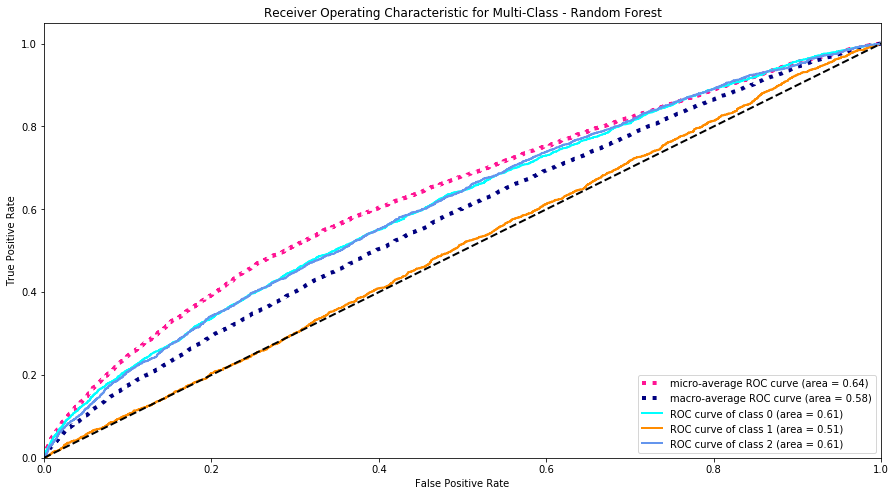

In [246]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class - Random Forest')
plt.legend(loc="lower right")


# Save options
save = 'images/roc_curve_random_forest'

if save:
    print('Saving graph to:', save + '.svg')
    plt.savefig(save + '.svg', format='svg')
    
    
plt.show()

## Confusion Matrix for Random Forest

Training Data Accuracy: 0.54
Test Data Accuracy:     0.48
[[ 173   22  843]
 [  99   22  797]
 [ 106   23 1564]]


             precision    recall  f1-score   support

       away       0.46      0.17      0.24      1038
       draw       0.33      0.02      0.04       918
       home       0.49      0.92      0.64      1693

avg / total       0.44      0.48      0.38      3649

Saving graph to: images/confusion_matrix_random_forest.svg


<Figure size 432x288 with 0 Axes>

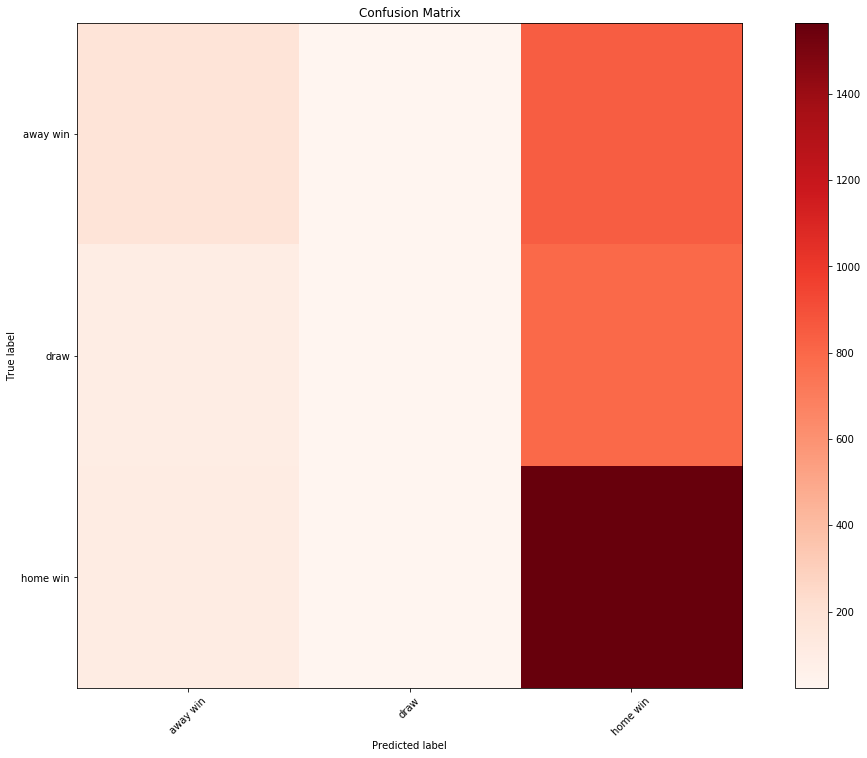

In [241]:
# test random forest
randomforest = RandomForestClassifier(max_depth=9,n_estimators=17,class_weight=None)
train_score(randomforest,X_updated,y)

# Save options
save = 'images/confusion_matrix_random_forest'

if save:
    print('Saving graph to:', save + '.svg')
    plt.savefig(save + '.svg', format='svg')

# grid search SVM with narrower scope of features

In [982]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1,1e-1,1e-2,1e-3, 1e-4],'C': [1, 10, 100, 1000]}]
#                     ,{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
#                     ,{'kernel':['poly'],'degree':[1,2,3]}]

scores = ['accuracy']
# scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, scoring=score,n_jobs=-1)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true_svm, y_pred_svm = y_test, clf.predict(X_test)
    print(classification_report(y_true_svm, y_pred_svm))
    print()

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Grid scores on development set:

0.443 (+/-0.003) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.473 (+/-0.002) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.470 (+/-0.001) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.459 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.459 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.435 (+/-0.005) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.420 (+/-0.002) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.472 (+/-0.002) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.469 (+/-0.002) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.459 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.435 (+/-0.005) for {'C': 100, 'gam

/Users/auyeus/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


             precision    recall  f1-score   support

       away       0.50      0.23      0.31      1570
       draw       0.30      0.02      0.05      1389
       home       0.49      0.91      0.64      2514

avg / total       0.44      0.49      0.39      5473




## ROC curve for rbf SVM

In [231]:
# Binarize the output
y_roc = label_binarize(y, classes=['home', 'draw', 'away'])
n_classes = y_roc.shape[1]

random_state = np.random.RandomState(0)


# shuffle and split training and test sets
X_train_roc, X_test_roc, y_train_roc, y_test_roc = train_test_split(X_updated, y_roc, test_size=.5,
                                                    random_state=0)


# Learn to predict each class against the other
classifier = OneVsRestClassifier(SVC(C=1, kernel='rbf',gamma=0.1),n_jobs=-1)

y_score = classifier.fit(X_train_roc, y_train_roc).decision_function(X_test_roc)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


Saving graph to: images/roc_curve_SVM_rbf.svg


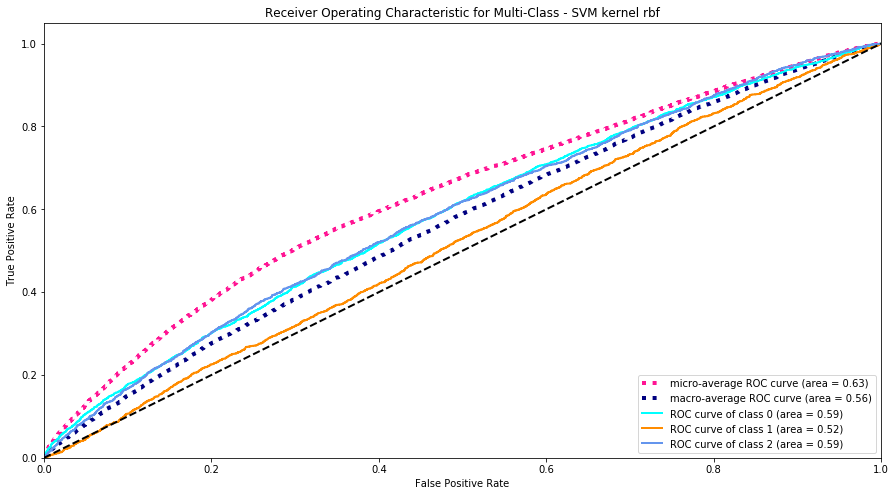

In [236]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class - SVM kernel rbf')
plt.legend(loc="lower right")


# Save options
save = 'images/roc_curve_SVM_rbf'

if save:
    print('Saving graph to:', save + '.svg')
    plt.savefig(save + '.svg', format='svg')
plt.show()

## Looking at the ROC curve for rbf SVM with optimal arguments, it looks like Random Forest still outperforms

# Let's check and see if logistic regression is any better

In [216]:
logreg = LogisticRegression(multi_class='multinomial',solver='newton-cg')

c_range = list(np.logspace(-3, 1, 256)) # range of alphas (basically)
tuned_parameters = dict(C=c_range)

scores = ['accuracy']
# scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(logreg, tuned_parameters, cv=5, scoring=score,n_jobs=-1)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true_svm, y_pred_svm = y_test, clf.predict(X_test)
    print(classification_report(y_true_svm, y_pred_svm))
    print()

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

LogisticRegression(C=0.0065416344898951515, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

Grid scores on development set:

0.470 (+/-0.002) for {'C': 0.001}
0.470 (+/-0.002) for {'C': 0.001036779197060366}
0.470 (+/-0.002) for {'C': 0.001074911103457137}
0.470 (+/-0.002) for {'C': 0.0011144454707535626}
0.470 (+/-0.002) for {'C': 0.00115543388033544}
0.470 (+/-0.002) for {'C': 0.0011979298107105216}
0.470 (+/-0.002) for {'C': 0.0012419887072831308}
0.470 (+/-0.002) for {'C': 0.001287668054695046}
0.470 (+/-0.002) for {'C': 0.0013350274518270132}
0.470 (+/-0.002) for {'C': 0.0013841286895587572}
0.470 (+/-0.002) for {'C': 0.0014350358313889448}
0.470 (+/-0.002) for {'C': 0.0014878152970202849}

/Users/auyeus/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/auyeus/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [233]:
# Binarize the output
y_roc = label_binarize(y, classes=['home', 'draw', 'away'])
n_classes = y_roc.shape[1]

random_state = np.random.RandomState(0)


# shuffle and split training and test sets
X_train_roc, X_test_roc, y_train_roc, y_test_roc = train_test_split(X_updated, y_roc, test_size=.5,
                                                    random_state=0)


# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(C=0.0065416344898951515,multi_class='multinomial',solver='newton-cg'),n_jobs=-1)

y_score = classifier.fit(X_train_roc, y_train_roc).decision_function(X_test_roc)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

Saving graph to: images/roc_curve_LR.svg


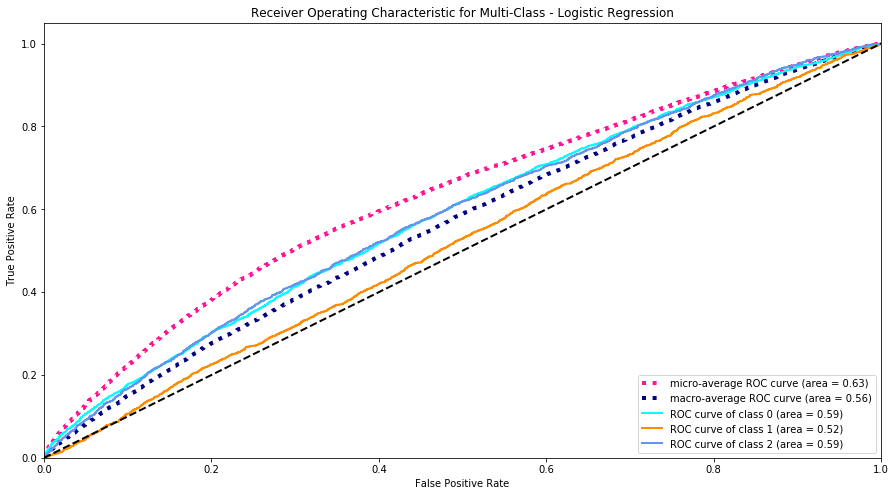

In [237]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class - Logistic Regression')
plt.legend(loc="lower right")


# Save options
save = 'images/roc_curve_LR'

if save:
    print('Saving graph to:', save + '.svg')
    plt.savefig(save + '.svg', format='svg')
    
plt.show()

# Next steps:
narrow it down to three features:
- defence pressure
- chance creation positioning class (free form vs. organised)
- build up play passing

In [142]:
X_final = X_updated[['defencePressure_x','defencePressure_y','buildUpPlayPassing_x','buildUpPlayPassing_y',
           'chanceCreationPositioningClass_Free Form_x','chanceCreationPositioningClass_Free Form_y',
           'chanceCreationPositioningClass_Organised_x','chanceCreationPositioningClass_Organised_y']]

In [143]:
df_final = pd.concat([y,X_final],axis=1)
df_final.head(5)

,winner,defencePressure_x,defencePressure_y,buildUpPlayPassing_x,buildUpPlayPassing_y,chanceCreationPositioningClass_Free Form_x,chanceCreationPositioningClass_Free Form_y,chanceCreationPositioningClass_Organised_x,chanceCreationPositioningClass_Organised_y
0,home,70.0,60.0,35.0,40.0,0.0,0.0,1.0,1.0
1,away,70.0,70.0,50.0,40.0,0.0,0.0,1.0,1.0
2,home,60.0,70.0,60.0,35.0,0.0,0.0,1.0,1.0
3,home,60.0,70.0,40.0,60.0,0.0,0.0,1.0,1.0
4,away,70.0,70.0,40.0,35.0,0.0,0.0,1.0,1.0


In [144]:
path_folder = 'data/'

# save merge_table_final
with open(path_folder + 'df_final.pkl','wb') as picklefile:
    pickle.dump(df_final,picklefile)

In [195]:
# load pickle files
with open(path_folder + 'df_final.pkl','rb') as picklefile:
    df_final = pickle.load(picklefile)

In [196]:
y = df_final['winner']

In [197]:
X_final = df_final.iloc[:,1:]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, stratify=y)

In [42]:
scaler = StandardScaler()

# standardize the features' values
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [995]:
# let's try GridSearchCV one more time on final features

# define the parameter values that should be searched
estimate_range = list(range(10,20))
depth_range = list(range(1, 20))
weight_options = ['balanced', None]

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_estimators=estimate_range,max_depth=depth_range, class_weight=weight_options)
#print(param_grid)

randomforest = RandomForestClassifier()

clf = GridSearchCV(randomforest, param_grid, cv=5, scoring='accuracy',n_jobs=-1,verbose=True)
clf.fit(X_train,y_train)

Fitting 5 folds for each of 380 candidates, totalling 1900 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1900 out of 1900 | elapsed:  1.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=True)

In [996]:
print(clf.best_params_)
print(clf.best_score_)

{'class_weight': None, 'max_depth': 7, 'n_estimators': 16}
0.47094753328112765


In [43]:
# Binarize the output
y_roc = label_binarize(y, classes=['home', 'draw', 'away'])
n_classes = y_roc.shape[1]

random_state = np.random.RandomState(0)


# shuffle and split training and test sets
X_train_roc, X_test_roc, y_train_roc, y_test_roc = train_test_split(X_final, y_roc, test_size=.5,
                                                    random_state=0)


# Learn to predict each class against the other
classifier = OneVsRestClassifier(RandomForestClassifier(max_depth=7,n_estimators=16,class_weight=None),n_jobs=-1)

y_score = classifier.fit(X_train_roc, y_train_roc).predict_proba(X_test_roc)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

Saving graph to: images/roc_curve_random_forest.svg


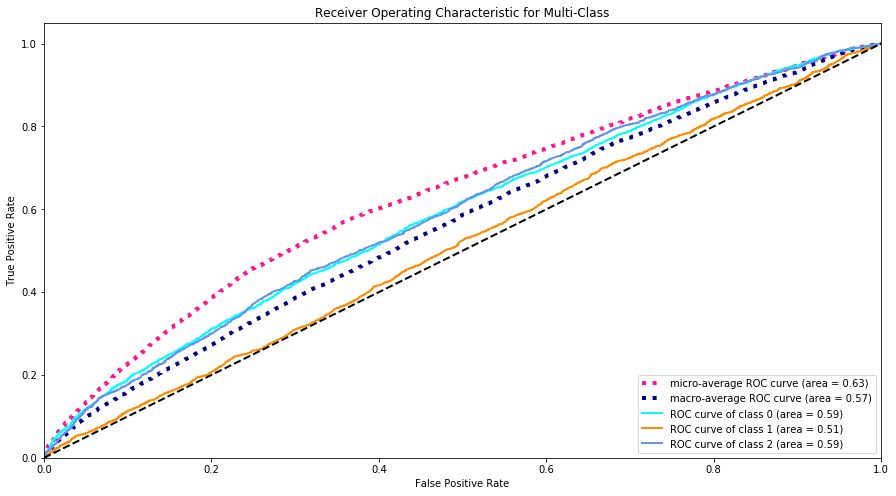

In [204]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")

# Save options
save = 'images/roc_curve_random_forest'

if save:
    print('Saving graph to:', save + '.svg')
    plt.savefig(save + '.svg', format='svg')
    
plt.show()



Training Data Accuracy: 0.44
Test Data Accuracy:     0.40
[[426 353 259]
 [276 336 306]
 [407 605 681]]


             precision    recall  f1-score   support

       away       0.38      0.41      0.40      1038
       draw       0.26      0.37      0.30       918
       home       0.55      0.40      0.46      1693

avg / total       0.43      0.40      0.40      3649

Saving graph to: images/confusion_matrix_logreg.svg


<Figure size 432x288 with 0 Axes>

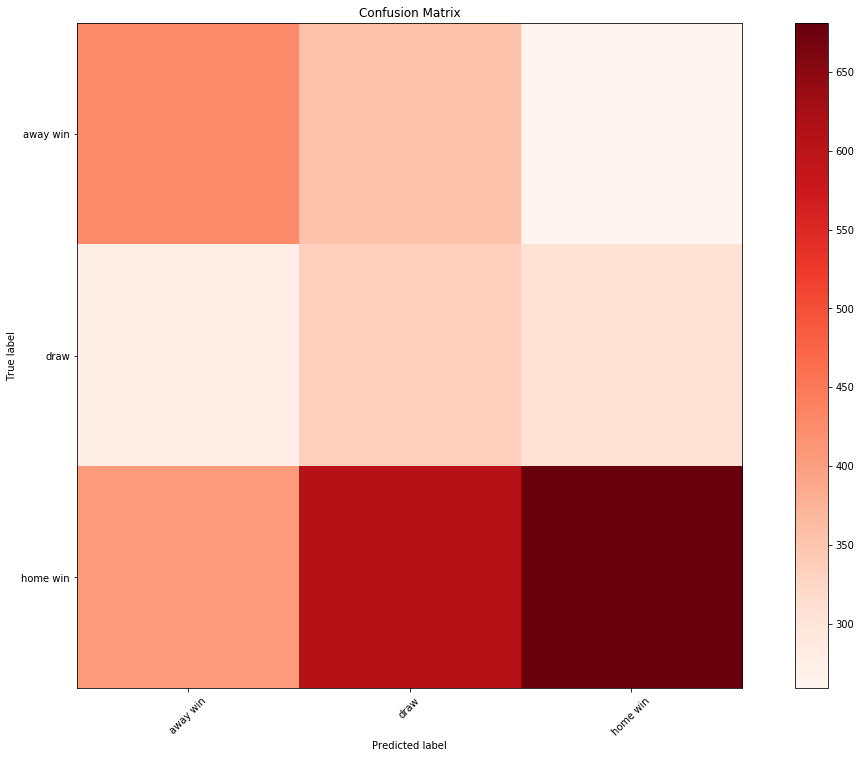

In [200]:
# test random forest
randomforest = RandomForestClassifier(max_depth=7,n_estimators=16,class_weight='balanced')
train_score(randomforest,X_final,y)

# Testing Random Forest outcome

In [148]:
scaler = StandardScaler()

# standardize the features' values
X_rf = scaler.fit_transform(X_final)

In [149]:
rf = RandomForestClassifier(max_depth=7,n_estimators=16,class_weight=None)
PREDICTOR = rf.fit(X_rf,y)
#outcome_predict = test_result.predict(X_rf)

In [150]:
X_final.iloc[0]

defencePressure_x                             70.0
defencePressure_y                             60.0
buildUpPlayPassing_x                          35.0
buildUpPlayPassing_y                          40.0
chanceCreationPositioningClass_Free Form_x     0.0
chanceCreationPositioningClass_Free Form_y     0.0
chanceCreationPositioningClass_Organised_x     1.0
chanceCreationPositioningClass_Organised_y     1.0
Name: 0, dtype: float64

In [177]:
data = {}

In [178]:
data['example'] = [50.0,50.0,50.0,50.0,'Organised','Free Form']


In [179]:
data

{'example': [50.0, 50.0, 50.0, 50.0, 'Organised', 'Free Form']}

In [180]:
data_updated= data['example'][0:4]
data_updated

[50.0, 50.0, 50.0, 50.0]

In [181]:
if (data['example'][-2] == 'Free Form') & (data['example'][-1]=='Free Form'):
    data_updated.extend([1.0,1.0,0.0,0.0])
elif (data['example'][-2] == 'Free Form') & (data['example'][-1]=='Organised'):
    data_updated.extend([1.0,0.0,0.0,1.0])
elif (data['example'][-2] == 'Organised') & (data['example'][-1]=='Free Form'):
    data_updated.extend([0.0,1.0,1.0,0.0])
elif (data['example'][-2] == 'Ordinal') & (data['example'][-1]=='Ordinal'):
    data_updated.extend([0.0,0.0,1.0,1.0])
    

In [182]:
data['scenario'] = data_updated

In [183]:
data

{'example': [50.0, 50.0, 50.0, 50.0, 'Organised', 'Free Form'],
 'scenario': [50.0, 50.0, 50.0, 50.0, 0.0, 1.0, 1.0, 0.0]}

In [184]:
x = np.matrix(data["scenario"])


In [185]:
x

matrix([[50., 50., 50., 50.,  0.,  1.,  1.,  0.]])

In [186]:
score = test_result.predict(x)


In [189]:
score

array(['away'], dtype=object)

In [190]:
score[0]

'away'

In [191]:
# Put the result in a nice dict so we can send it as json
results = {"score": score[0]}

In [192]:
results

{'score': 'away'}

# Decision Threshold (does not support multi-class...)

In [ ]:
# create array of class probabilities
y_scores = rf_model.predict_proba(X_test)

# generate precision-recall curve for the classifier
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [957]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

# going to try and gridSearch scores (precision) - does not support multiclass..

In [968]:
clf = OneVsRestClassifier(RandomForestClassifier(),n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [969]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [ ]:
grid_search_clf = grid_search_wrapper(refit_score='accuracy_score')

# Match Table

- 25,979 records
- 115 columns

In [83]:
match_table.head(3)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.5,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75


In [298]:
# premier league home teams
match_table.loc[match_table['league_id']==1729]['home_team_api_id'].unique()

array([10260,  9825,  8472,  8654, 10252,  8668,  8549,  8559,  8667,
        8455, 10194,  8650, 10261,  9879,  8586,  8659,  8462,  8456,
        8655,  8528,  8602,  8191,  8658,  8483, 10172,  9850, 10003,
        9798,  8466,  9826,  8344,  8197,  8678,  9817])

In [299]:
# premier league away teams
match_table.loc[match_table['league_id']==1729]['away_team_api_id'].unique()

array([10261,  8659,  8650,  8528,  8456,  8655,  8586, 10194,  9879,
        8462,  8654,  8668,  8455,  8472,  8667, 10252,  9825, 10260,
        8549,  8559,  8658,  8191,  8602,  8483, 10003,  9850, 10172,
        8466,  9798,  8344,  9826,  8197,  9817,  8678])

## match_table columns related to player IDs

In [682]:
match_table.iloc[:,55:77].tail(5)

,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
25974,42231.0,678384.0,95220.0,638592.0,413155.0,45780.0,171229.0,67333.0,119839.0,143790.0,...,563066.0,8800.0,67304.0,158253.0,133126.0,186524.0,93223.0,121115.0,232110.0,289732.0
25975,33272.0,41621.0,25813.0,257845.0,114735.0,42237.0,113227.0,358156.0,32343.0,531309.0,...,114792.0,150007.0,178119.0,27232.0,570830.0,260708.0,201704.0,36382.0,34082.0,95257.0
25976,157856.0,274779.0,177689.0,294256.0,42258.0,39979.0,173936.0,147959.0,451983.0,80564.0,...,67349.0,202663.0,32597.0,114794.0,188114.0,25840.0,482200.0,95230.0,451335.0,275122.0
25977,NaN,8881.0,173534.0,39646.0,282287.0,340790.0,393337.0,8893.0,614454.0,93229.0,...,121080.0,197757.0,260964.0,231614.0,113235.0,41116.0,462608.0,42262.0,92252.0,194532.0
25978,274787.0,492132.0,108451.0,25815.0,94553.0,384376.0,598355.0,36785.0,45174.0,302079.0,...,95216.0,172768.0,22834.0,458806.0,207234.0,25772.0,40274.0,34035.0,41726.0,527103.0


## associated player table data (look up via player_api_id)

In [683]:
player_table.loc[player_table['player_api_id']==274787]

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
10989,11005,274787,Yvon Mvogo,206003,1994-06-06 00:00:00,187.96,185


In [684]:
# number of players
len(player_table['player_api_id'].unique())

11060

In [687]:
# number of teams
len(team_table['team_api_id'].unique())

299

## match_table columns related to league, season, date, home/away teams, goals

In [236]:
match_table.iloc[144:150,:11]

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
144,145,1,1,2008/2009,24,2009-02-28 00:00:00,493016,9996,8635,1,1
145,146,1,1,2008/2009,24,2009-02-27 00:00:00,493017,8203,9987,2,1
146,147,1,1,2008/2009,24,2009-02-28 00:00:00,493018,9986,9998,3,0
147,148,1,1,2008/2009,24,2009-03-01 00:00:00,493019,9985,9984,4,0
148,149,1,1,2008/2009,24,2009-03-01 00:00:00,493020,9994,9991,0,1
149,150,1,1,2008/2009,24,2009-02-28 00:00:00,493021,8342,9999,2,1


### columns related to player IDs

In [114]:
match_table.columns[55:77]

Index(['home_player_1', 'home_player_2', 'home_player_3', 'home_player_4',
       'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8',
       'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1',
       'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5',
       'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9',
       'away_player_10', 'away_player_11'],
      dtype='object')

### columns related to team ID

In [153]:
match_table.columns[0:11]

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal'],
      dtype='object')

### columns related to betting odds + other match stats

In [224]:
match_table.columns[77:115]

Index(['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner',
       'possession', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH',
       'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD',
       'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA',
       'BSH', 'BSD', 'BSA'],
      dtype='object')

### looking at the data for the following features, looks like the web scrape did not work properly

Features impacted include:
- goal
- shoton
- shotoff
- foulcommit
- card
- cross
- corner
- possession

In [325]:
match_table.loc[match_table['goal'].notnull(),['goal','shoton','shotoff','foulcommit','card','cross','corner',
                                             'possession']].head(3)

,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
1728,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...
1729,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...
1730,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...


In [362]:
match_table.iloc[:,85:]

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
24550,3.80,3.80,1.91,3.90,3.90,1.95,3.80,3.6,1.85,3.60,...,NaN,3.90,4.00,1.93,NaN,NaN,NaN,NaN,NaN,NaN
24551,2.63,3.20,2.80,2.70,3.00,2.75,2.60,3.2,2.60,2.62,...,NaN,2.75,3.13,2.90,NaN,NaN,NaN,NaN,NaN,NaN
24552,1.57,3.80,6.50,1.57,4.00,6.50,1.65,3.7,4.90,1.57,...,NaN,1.57,4.00,7.00,NaN,NaN,NaN,NaN,NaN,NaN
24553,2.25,3.25,3.40,2.35,3.10,3.10,2.20,3.2,3.20,2.25,...,NaN,2.30,3.40,3.40,NaN,NaN,NaN,NaN,NaN,NaN
24554,1.53,4.00,7.00,1.55,4.00,6.50,1.60,3.7,5.40,1.50,...,NaN,1.55,4.20,7.00,NaN,NaN,NaN,NaN,NaN,NaN
24555,2.30,3.25,3.25,2.35,3.25,3.00,2.40,3.3,2.75,2.30,...,NaN,2.30,3.40,3.30,NaN,NaN,NaN,NaN,NaN,NaN
24556,2.20,3.40,3.20,2.25,3.50,3.20,2.30,3.3,2.90,2.10,...,NaN,2.20,3.60,3.50,NaN,NaN,NaN,NaN,NaN,NaN
24557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Columns in match_table may be player position data (columns 11 through 54)

In [160]:
match_table.columns[11:55]

Index(['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4',
       'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8',
       'home_player_X9', 'home_player_X10', 'home_player_X11',
       'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4',
       'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8',
       'away_player_X9', 'away_player_X10', 'away_player_X11',
       'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4',
       'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8',
       'home_player_Y9', 'home_player_Y10', 'home_player_Y11',
       'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4',
       'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8',
       'away_player_Y9', 'away_player_Y10', 'away_player_Y11'],
      dtype='object')

In [182]:
match_table.loc[(match_table['home_player_X5'].notnull()) & (match_table['home_player_Y5'].notnull()),
                ['home_player_X5','home_player_Y5']].head(3)

,home_player_X5,home_player_Y5
144,8.0,3.0
145,8.0,3.0
146,8.0,3.0


In [73]:
sqlite_sequence_table

,name,seq
0,Team,103916
1,Country,51958
2,League,51958
3,Match,51958
4,Player,11075
5,Player_Attributes,183978
6,Team_Attributes,1458


## Transforming nominal, categorical data

In [117]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# transform feature country into numerical representation
country_le = LabelEncoder()
country_labels = country_le.fit_transform(league_country_table['country'])
country_mappings = {index: label for index, label in 
                  enumerate(country_le.classes_)}
#country_mappings

#country_labels

### map the transformed country data to the main table

In [118]:
league_country_table['country_label'] = country_labels

In [119]:
league_country_table

,id,country_id,league,country,country_label
0,1,1,Belgium Jupiler League,Belgium,0
1,1729,1729,England Premier League,England,1
2,4769,4769,France Ligue 1,France,2
3,7809,7809,Germany 1. Bundesliga,Germany,3
4,10257,10257,Italy Serie A,Italy,4
5,13274,13274,Netherlands Eredivisie,Netherlands,5
6,15722,15722,Poland Ekstraklasa,Poland,6
7,17642,17642,Portugal Liga ZON Sagres,Portugal,7
8,19694,19694,Scotland Premier League,Scotland,8
9,21518,21518,Spain LIGA BBVA,Spain,9


## For ordinal, categorical data, we may need to transform them via custom dictionaries

Example below:

## after transforming data into numerical values, we need to set them as dummy variables

In [120]:
# encode generation labels using one-hot encoding scheme
country_ohe = OneHotEncoder()
country_feature_arr = country_ohe.fit_transform(
                              league_country_table[['country_label']]).toarray()
country_feature_labels = list(country_le.classes_)
country_features = pd.DataFrame(country_feature_arr, 
                            columns=country_feature_labels)

# # encode legendary status labels using one-hot encoding scheme
# leg_ohe = OneHotEncoder()
# leg_feature_arr = leg_ohe.fit_transform(
#                                 poke_df[['Lgnd_Label']]).toarray()
# leg_feature_labels = ['Legendary_'+str(cls_label) 
#                            for cls_label in leg_le.classes_]
# leg_features = pd.DataFrame(leg_feature_arr, 
#                             columns=leg_feature_labels)

In [121]:
country_features

,Belgium,England,France,Germany,Italy,Netherlands,Poland,Portugal,Scotland,Spain,Switzerland
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Concatenate your dummy variables with the main dataframe

In [122]:
league_country_df_ohe = pd.concat([league_country_table, country_features], axis=1)
columns = sum([list(league_country_table.columns),   
               country_feature_labels], [])
league_country_df_ohe[columns]

,id,country_id,league,country,country_label,Belgium,England,France,Germany,Italy,Netherlands,Poland,Portugal,Scotland,Spain,Switzerland
0,1,1,Belgium Jupiler League,Belgium,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1729,1729,England Premier League,England,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4769,4769,France Ligue 1,France,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7809,7809,Germany 1. Bundesliga,Germany,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10257,10257,Italy Serie A,Italy,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,13274,13274,Netherlands Eredivisie,Netherlands,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,15722,15722,Poland Ekstraklasa,Poland,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,17642,17642,Portugal Liga ZON Sagres,Portugal,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,19694,19694,Scotland Premier League,Scotland,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,21518,21518,Spain LIGA BBVA,Spain,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Adaptive Binning

Another transformation to consider - breaking up a feature into buckets (2-quantiles, 4-quantiles, even 10-quantiles)

In [ ]:
quantile_list = [0, .25, .5, .75, 1.]
quantiles = fcc_survey_df['Income'].quantile(quantile_list)
quantiles

## For features with skewed continuous data - we will need to perform some sort of transformation - LOG or BOX-COX

These power functions have a **pre-requisite that the numeric values to be transformed must be positive**. In case they are negative, shifting using a constant value helps.

**Log transforms** are useful when applied to skewed distributions as they **tend to expand the values which fall in the range of lower magnitudes** and **tend to compress or reduce the values which fall in the range of higher magnitudes.** This tends to make the skewed distribution as normal-like as possible.

**Example of Log Transformation below:**

In [ ]:
fcc_survey_df['Income_log'] = np.log((1+ fcc_survey_df['Income']))
fcc_survey_df[['ID.x', 'Age', 'Income', 'Income_log']].iloc[4:9]

In [ ]:
# plotting the distribution of log transformed feature
income_log_mean = np.round(np.mean(fcc_survey_df['Income_log']), 2)
fig, ax = plt.subplots()
fcc_survey_df['Income_log'].hist(bins=30, color='#A9C5D3', 
                                 edgecolor='black', grid=False)
plt.axvline(income_log_mean, color='r')
ax.set_title('Developer Income Histogram after Log Transform', 
             fontsize=12)
ax.set_xlabel('Developer Income (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(11.5, 450, r'$\mu$='+str(income_log_mean), fontsize=10)

**The optimal value of λ is usually determined using a maximum likelihood or log-likelihood estimation.**

**Example of BOX-COX below:**

In [ ]:
# getting the optimal box-cox lambda

income = np.array(fcc_survey_df['Income'])
income_clean = income[~np.isnan(income)] # remove non-null values
l, opt_lambda = spstats.boxcox(income_clean)
print('Optimal lambda value:', opt_lambda)

In [ ]:
# applying lambda = 0 to feature of choice (this is basically log transformation)
fcc_survey_df['Income_boxcox_lambda_0'] = spstats.boxcox(
                                        (1+fcc_survey_df['Income']), 
                                          lmbda=0)

# applying optimal lambda to feature of choice
fcc_survey_df['Income_boxcox_lambda_opt'] = spstats.boxcox(
                                            fcc_survey_df['Income'], 
                                              lmbda=opt_lambda)

# outputting both results
fcc_survey_df[['ID.x', 'Age', 'Income', 'Income_log', 
               'Income_boxcox_lambda_0',       
               'Income_boxcox_lambda_opt']].iloc[4:9]

In [ ]:
# plotting the distribution of box-cox transformed feature

income_boxcox_mean = np.round(
                      np.mean(
                       fcc_survey_df['Income_boxcox_lambda_opt']),2)
fig, ax = plt.subplots()
fcc_survey_df['Income_boxcox_lambda_opt'].hist(bins=30, 
                     color='#A9C5D3', edgecolor='black', grid=False)
plt.axvline(income_boxcox_mean, color='r')
ax.set_title('Developer Income Histogram after Box–Cox Transform', 
             fontsize=12)
ax.set_xlabel('Developer Income (Box–Cox transform)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(24, 450, r'$\mu$='+str(income_boxcox_mean), fontsize=10)